<h2><b>Initial Setup</b></h2>
<p>Let's Start by mounting our google drive folder to Colab</p>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<p>unzip the files to current folder</p>

In [2]:
!unzip -n -qq "/content/gdrive/MyDrive/Image class/Traffic sign Image class.zip"

<p>Importing necessary packages.</p>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tqdm import tqdm
from os import listdir, makedirs
from os.path import join

<p>Code to check and use gpu if the system has gpu, if not then cpu will be used.</p>

In [5]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 16  # Number of images used in each iteration
    EPOCHS = 3  # Number of passes through entire dataset
    print("Using GPU for training!")

# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 4
    EPOCHS = 1
    print("Using CPU for training")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Using CPU for training


<h2><b>Data preprocessing</b></h2>
<p>Uploading image training data placed inside folder:'train' and printing total number of images and classes</p>

In [6]:
data_dir = '/content/' # ADD path/to/dataset
labels = pd.read_csv(join(data_dir, 'labels_tr.csv')) # EDIT WITH YOUR LABELS FILE NAME
print("Total number of images in the dataset: {}".format(len(listdir(join(data_dir, 'train')))))
print(labels['labels']. nunique())

Total number of images in the dataset: 2055
16


<p> We have 16 classes for 2055 total images, now if required we can only select top 'x' classes according project requirement or system limitation. We are going forward wth selecting all the classes. 'NUM_CLASSES' represents number of classes considered.</p>

In [7]:
# Keeping all 16 classes
NUM_CLASSES = 16

print("Top {} labels (sorted by number of samples)".format(NUM_CLASSES))
(labels
 .groupby("labels")
 .count()
 .sort_values("filename", ascending=False)
 .head(NUM_CLASSES)
)

Top 16 labels (sorted by number of samples)


filename
labels                             
roundabout                      168
no_entry                        162
speed_limit_80                  152
bicycle_track                   150
turn_left                       143
no_vehicle_entry                142
school_zone                     140
no_honking                      130
no_overtaking                   128
keep_right                      126
road_humps_ahead                124
stop                            119
keep_left                       107
turn_right                      100
speed_limit_50                   98
pedestrian_crossing_ahead        66

In [8]:
import numpy as np
import requests

from os.path import join
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.applications import xception

from mpl_toolkits.axes_grid1 import ImageGrid

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2><b>Train-Test validation split</b></h2>
<p>We split the dataset into two sets, one for training and one for validation by defining the split and using it later in training. Splitting the dataset is a common step when the validation and/or test sets are not provided.</p>

In [28]:
def split_train_val(labels, num_classes, seed=1234):
    selected_sign_list = list(labels.groupby('labels').count().sort_values(by='filename', ascending=False).head(num_classes).index)
    labels = labels.loc[labels['labels'].isin(selected_sign_list)].copy().reset_index(drop=True)
    labels['target'] = 1
    labels['rank'] = labels.groupby('labels').rank()['filename']
    labels_pivot = labels.pivot(index='filename', columns='labels', values='target').reset_index().fillna(0)
    np.random.seed(seed=seed)
    rnd = np.random.random(len(labels))
    train_idx = rnd < 0.95
    valid_idx = rnd >= 0.95
    y_train = labels_pivot[selected_sign_list].values
    ytr = y_train[train_idx]
    yv = y_train[valid_idx]
    return (train_idx, valid_idx, ytr, yv, labels, selected_sign_list)

In [29]:
def read_img(img_id, data_dir, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """

    img = image.load_img(join(data_dir, train_or_test, img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [30]:
def show_images(num_classes, labels, data_dir):
    j = int(np.sqrt(num_classes))
    i = int(np.ceil(1. * num_classes / j))
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
    for i, (img_id, labels) in enumerate(labels.loc[labels['rank'] == 1, ['filename', 'labels']].values):
        ax = grid[i]
        img = read_img(img_id, data_dir, 'train', (224, 224))
        ax.imshow(img / 255.)
        ax.text(10, 200, 'LABEL: %s' % labels, color='k', backgroundcolor='w', alpha=0.8)
        ax.axis('off')
    plt.show()

In [31]:
def data_augmentation_example(input_path, count):
    # load image to array
    image = img_to_array(load_img(input_path))

    # reshape to array rank 4
    image = image.reshape((1,) + image.shape)

    # let's create infinite flow of images
    train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
    images_flow = train_datagen.flow(image, batch_size=1)

    plt.figure(figsize=(9,9))
    for idx, new_images in enumerate(images_flow):
        if idx < count:
            plt.subplot(330 + 1 + idx)
            new_image = array_to_img(new_images[0], scale=True)
            plt.imshow(new_image)
            plt.axis('off')
        else:
            plt.show()
            break

In [32]:
def prediction_from_url(url, model, selected_breed_list):
    test_image_path = '/tmp/test.jpg'
    response = requests.get(url)
    if response.status_code == 200:
        with open(test_image_path, 'wb') as f:
            f.write(response.content)
    img = read_img('test', '/', 'tmp', (224, 224))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    pred_idx = np.argmax(preds, axis=1)[0]
    plt.title('Prediction: %s (%.2f)' % (selected_breed_list[pred_idx] , preds[0][pred_idx]*100))
    plt.imshow(img / 255.)
    plt.axis('off')
    plt.show()

In [33]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.

    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix.
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.

    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure

    FROM: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

<h2><b>Data Augmentation</b></h2>
<p>Since we have only a few samples per label, we will
<li>Set up a Transfer Learning task using the Xception model (pre-trained on ImageNet)</li>
<li>Use data augmentation to artificially increase the number of training images.</li></p>
<p>We do this by manipulating (scaling, zooming, rotating, etc.) the input images.</p>
<p>Here is an example of what data augmentation does</p>

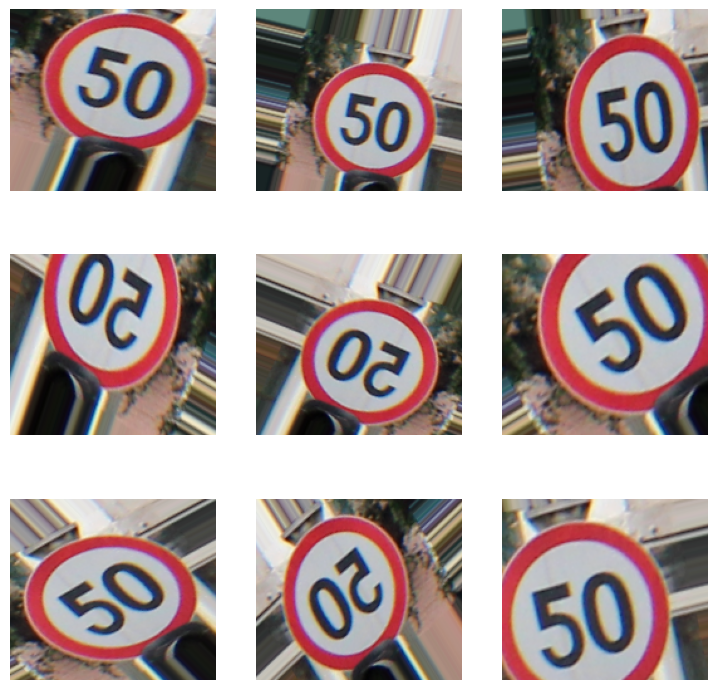

In [34]:
input_path = '/content/train/004_ (5).png' # An example image from the dataset
count = 9 # Number of samples to show

data_augmentation_example(input_path, count)

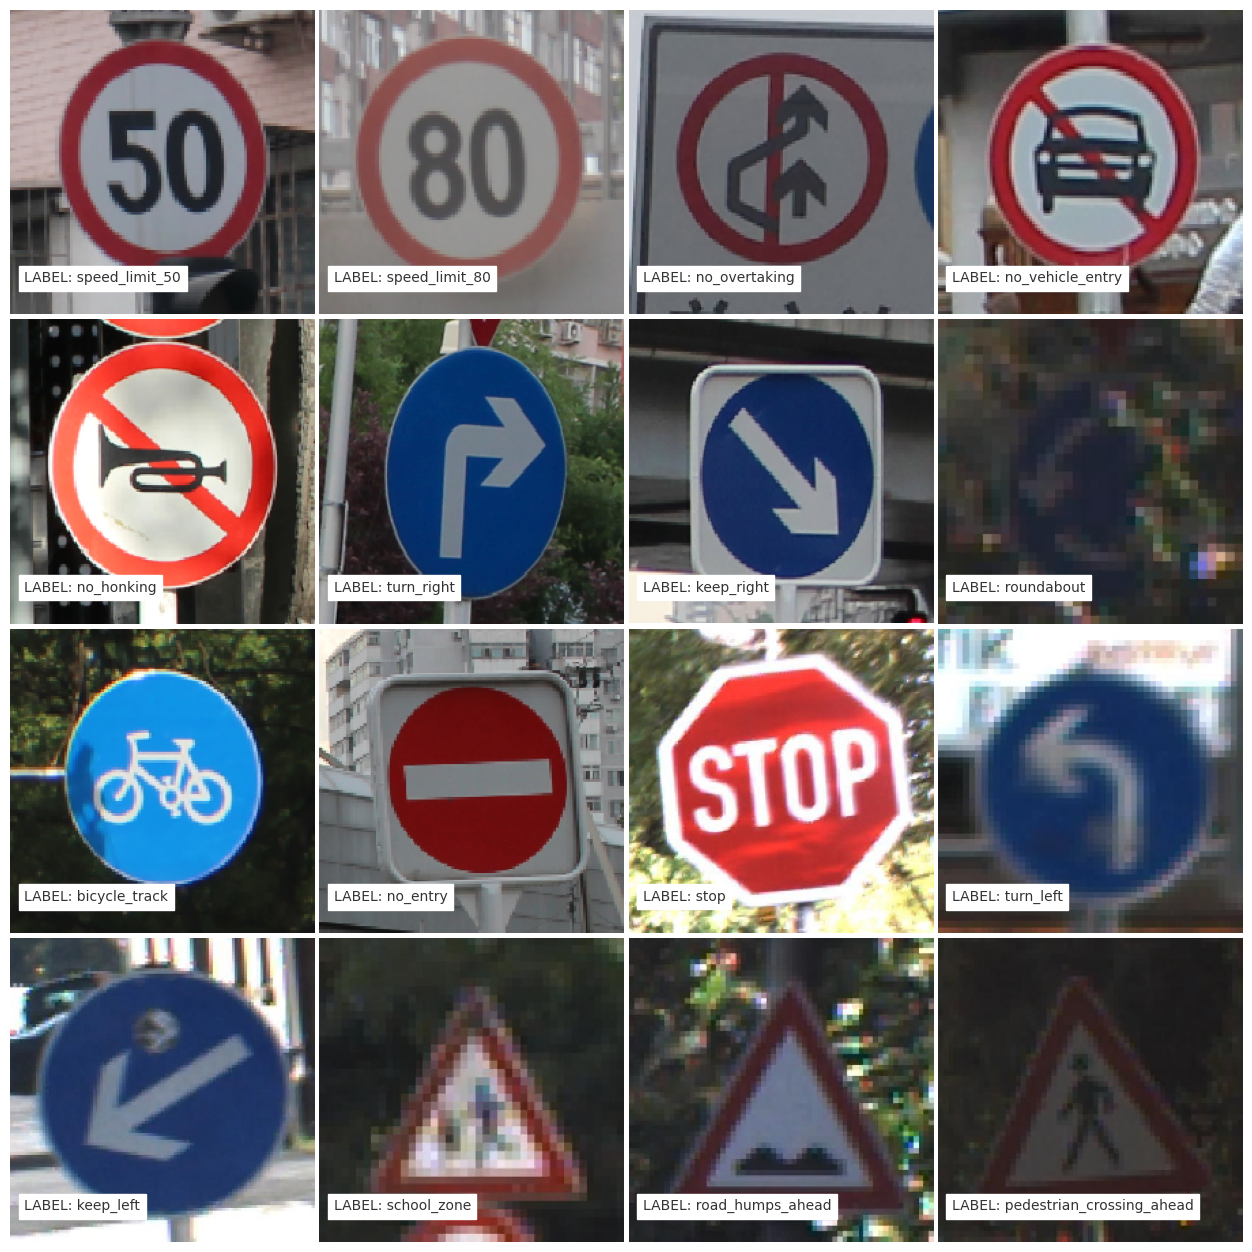

In [35]:
# Make sure to have the same split
SEED = 2018

(train_idx, valid_idx, ytr, yv, labels, selected_sign_list) = split_train_val(labels, NUM_CLASSES, seed=SEED)

from keras.preprocessing import image

show_images(NUM_CLASSES, labels, data_dir)

<p>Before feeding the data into the model, we have to preprocess the images.
<li>The xception.preprocess_input method will normalize the value of each pixel to a number between -1 and 1, sample-wise.</li>
<li>Data augmentation: The ImageDataGenerator class will apply the distortions (defined by the parameters) during the training process.</li>

<p><b>Note:</b>Be careful with data augmentation - the agumentation step is done during the training process and it could become a bottleneck in the input data pipeline if the CPU is not fast enough to provide the preprocessed/augmented data for GPU computation.</p>

In [36]:
# DATA LOADER
from tensorflow.keras.applications import xception

INPUT_SIZE = 299 # width/height of image in pixels (as expected by Xception model)

x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['filename'])):
    img = read_img(img_id, data_dir, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('\nTotal Images shape: {}'.format(x_train.shape))

Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print('Train (images, H, W, C):', Xtr.shape,
      '\nVal (images, H, W, C):', Xv.shape,
      '\n\nTrain samples (images, labels)', ytr.shape,
      '\nValidation samples (images, labels)', yv.shape)

# Data Loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator()

2055it [00:06, 320.65it/s]



Total Images shape: (2055, 299, 299, 3)
Train (images, H, W, C): (1949, 299, 299, 3) 
Val (images, H, W, C): (106, 299, 299, 3) 

Train samples (images, labels) (1949, 16) 
Validation samples (images, labels) (106, 16)


In [ ]:
#!pip install --upgrade keras

<p>To speed things up, we will apply Transfer Learning by building new layers on top of the pre-trained Xception model.</p>

In [41]:
### MODEL - BOTTLENECK FEATURES - OPTMIZER

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model
from keras import Input

# Download and create the pre-trained Xception model for transfer learning
base_model = xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have NUM_CLASSES classes
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = RMSprop(learning_rate=0.001, rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, None, None, 32) │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, None, None, 32) │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, None, None, 32) │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, None, None, 64) │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, None, None, 64) │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, None, None, 64) │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, None, None,     │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, None, None,     │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, None, None,     │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, None, None,     │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, None, None,     │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, None, None,     │          8,192 │ block1_conv2_act[0][0] │
│                           │ 128)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, None, None,     │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)       

 Total params: 22,984,248 (87.68 MB)

 Trainable params: 2,118,672 (8.08 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [42]:
# TRAINING
hist = model.fit(train_datagen.flow(Xtr, ytr, batch_size=BATCH_SIZE),
                           steps_per_epoch=train_idx.sum() // BATCH_SIZE,
                           epochs=EPOCHS,
                           validation_data=test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE),
                           validation_steps=valid_idx.sum() // BATCH_SIZE,
                           verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


487/487 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.5325 - loss: 1.5818 - val_accuracy: 0.7500 - val_loss: 1.2308


<h2><b>Evaluate on validation set</b></h2>
<h3><b>Plot confusion matrix and print F1 score report</b></h3>

In [43]:
# EVAL
test_gen = test_datagen.flow(Xv, yv, batch_size=BATCH_SIZE, shuffle=False)
probabilities = model.predict(test_gen, steps=(yv.shape[0]//BATCH_SIZE)+1)

27/27 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step


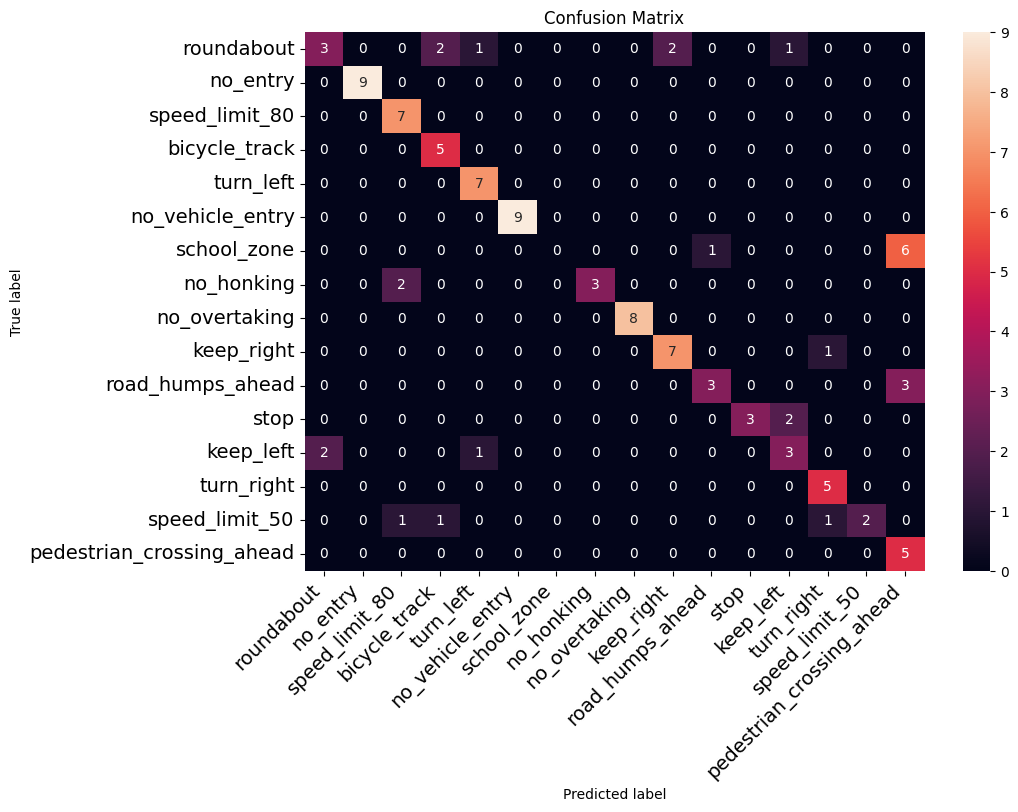

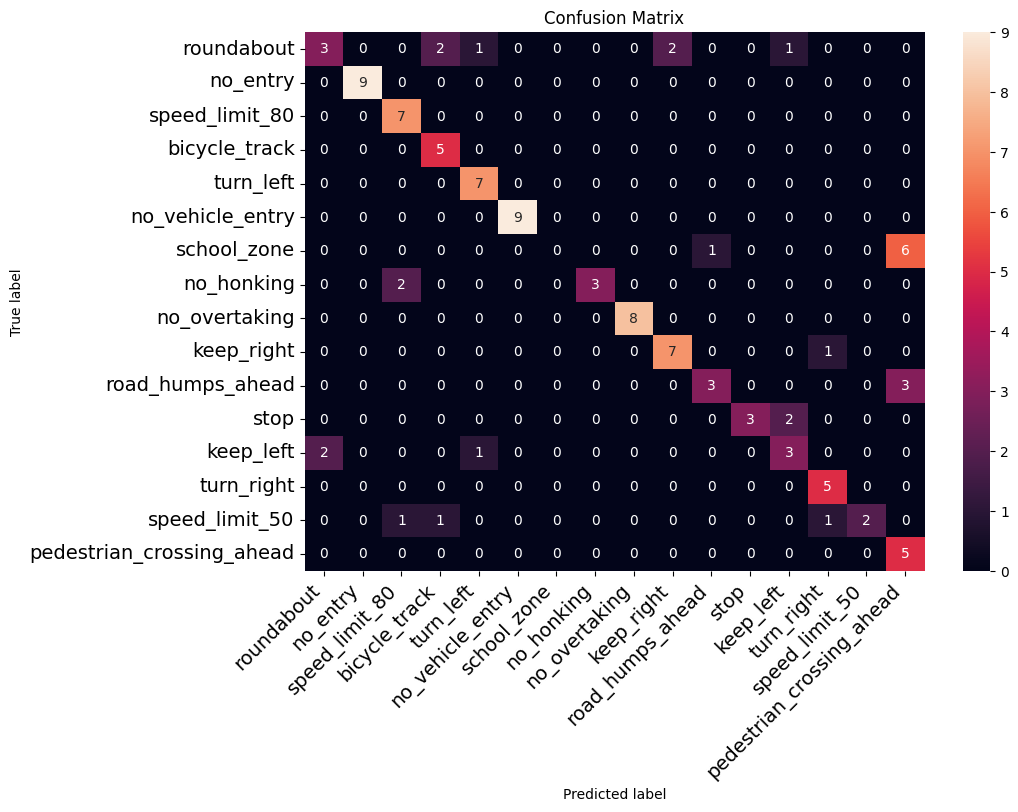

In [44]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(np.argmax(yv, axis=1), np.argmax(probabilities, axis=1))
print_confusion_matrix(cnf_matrix,selected_sign_list)

In [45]:
# Print Precision Recall F1-Score Report
from sklearn.metrics import classification_report

report = classification_report(np.argmax(probabilities,axis=1), np.argmax(yv, axis=1), target_names=selected_sign_list)
print(report)

                           precision    recall  f1-score   support

               roundabout       0.33      0.60      0.43         5
                 no_entry       1.00      1.00      1.00         9
           speed_limit_80       1.00      0.70      0.82        10
            bicycle_track       1.00      0.62      0.77         8
                turn_left       1.00      0.78      0.88         9
         no_vehicle_entry       1.00      1.00      1.00         9
              school_zone       0.00      0.00      0.00         0
               no_honking       0.60      1.00      0.75         3
            no_overtaking       1.00      1.00      1.00         8
               keep_right       0.88      0.78      0.82         9
         road_humps_ahead       0.50      0.75      0.60         4
                     stop       0.60      1.00      0.75         3
                keep_left       0.50      0.50      0.50         6
               turn_right       1.00      0.71      0.83     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<h2><b>Predicting unclassified images using trained model</b></h2>
<p>We will now predict unclassified images from a test set and use it to produce a csv file with a list of classifications made and then attach it to images of test set and visualise it.</p>

<p><b>note:</b>Unclassified images from internet can also be predicted as test image using its url. Variable defined as 'prediction_from_url' above can be used for that purpose.</p>

In [46]:
import os
import pandas as pd
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files

def predict_from_drive(image_path, model, selected_sign_list):
    img = image.load_img(image_path, target_size=(224, 224))  # Adjust target_size if needed
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize pixel values

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    predicted_sign = selected_sign_list[predicted_class]

    return predicted_sign  # Return the predicted breed instead of printing

# Folder path in Google Drive
folder_path = '/content/test_te'  # Replace with your actual folder path

# Initialize lists to store results
image_names = []
predicted_signs = []

# Iterate over images in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpg','.png')):  # Check for image files
        image_path = os.path.join(folder_path, filename)
        prediction = predict_from_drive(image_path, model, selected_sign_list)
        image_names.append(filename)
        predicted_signs.append(prediction)

# Create a Pandas DataFrame from the results
results_df = pd.DataFrame({'Image FileName': image_names, 'Predicted sign': predicted_signs})

# Save the DataFrame to an Excel file
results_df.to_csv('predicted_signs.csv', index=False)

# Download the Excel file
files.download('predicted_signs.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

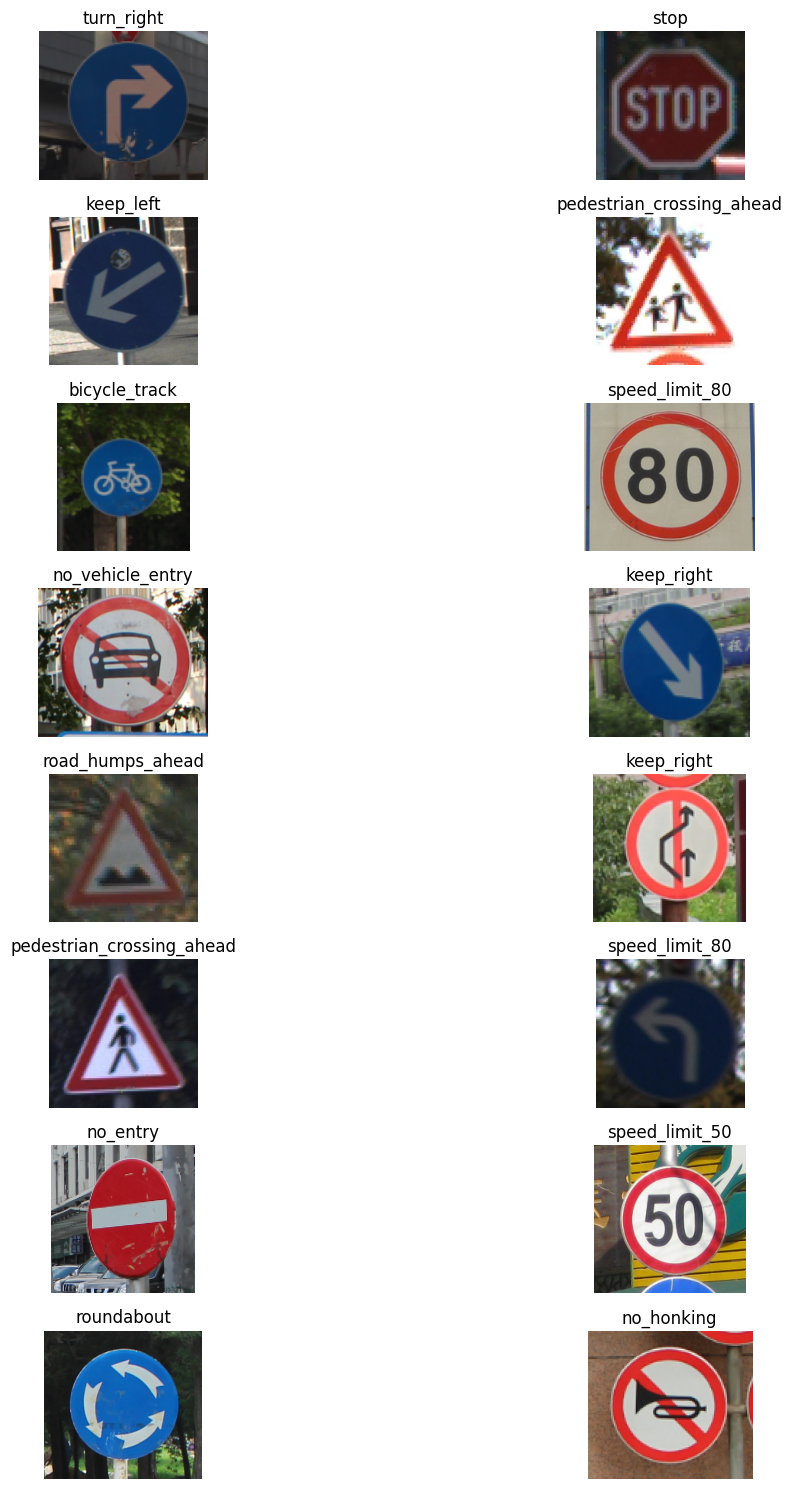

In [47]:
# prompt: i want above image test file's images and its predicted signs side by side

import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the results DataFrame
results_df = pd.read_csv('predicted_signs.csv')

# Set the folder path for the images
folder_path = '/content/test_te'  # Replace with your actual folder path

# Create a figure with subplots
fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(15, 15))

# Iterate through the first 16 rows of the DataFrame
for i in range(16):
    # Get the image filename and predicted sign
    image_filename = results_df.loc[i, 'Image FileName']
    predicted_sign = results_df.loc[i, 'Predicted sign']

    # Load the image
    image_path = os.path.join(folder_path, image_filename)
    image = mpimg.imread(image_path)

    # Get the current subplot
    ax = axes[i // 2, i % 2]

    # Display the image and the predicted sign
    ax.imshow(image)
    ax.set_title(predicted_sign)
    ax.axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
